In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import MobileNetV2


import matplotlib.pyplot as plt

import tempfile
from os import path
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Base custom model

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(28, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



## MNIST dataset

In [9]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



#### Constatns

In [10]:
# Model / data parameters
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)
MODEL_PATH = './mnist_models/first_mnist_model.h5'

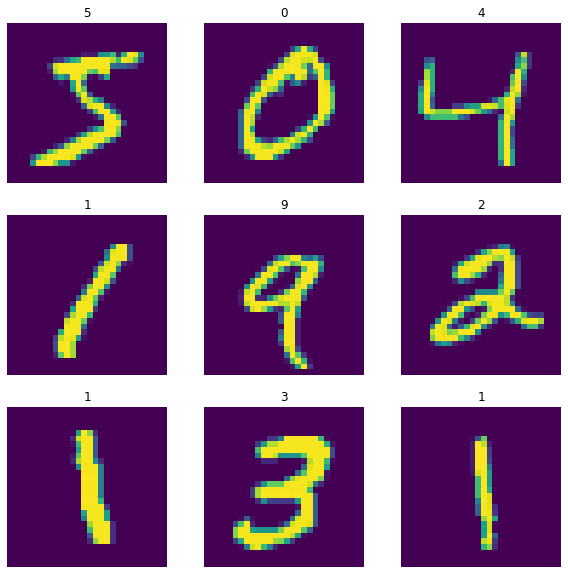

In [11]:


plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(int(train_labels[i]))
    plt.axis("off")
    
plt.show()

In [12]:
tf.dtypes.cast(train_images, tf.float32)
tf.dtypes.cast(test_images, tf.float32)

<tf.Tensor: shape=(10000, 28, 28), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

In [13]:
if path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # Compile
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
else:
    model = make_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

    # Train the digit classification model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(
        train_images,
        train_labels,
        epochs=4,
        validation_split=0.1,
        batch_size=64,
    )
    
    # save model
    model.save(MODEL_PATH)
    print('Saved')
    

In [14]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 25s 79ms/step - loss: 0.0533 - accuracy: 0.9819


[0.04520625248551369, 0.984499990940094]

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 28, 28, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 28)   56          rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 28, 28, 28)   112         conv2d_6[0][0]                   
____________________________________________________________________________________________

# CIFAR dataset

In [17]:
# Model / data parameters
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
MODEL_PATH = './cifar_models/first_cifar_model.h5'

In [18]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [19]:
if path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # Compile
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    print('Loaded from: ' + MODEL_PATH)
else:
    model = make_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

    # Train the digit classification model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    checkpoint_filepath = './tmp/'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit(
        train_images,
        train_labels,
        epochs=4,
        validation_split=0.1,
        batch_size=64,
        callbacks=[model_checkpoint_callback]
    )
    
    # save model
    model.save(MODEL_PATH)
    print('Saved to: ' + MODEL_PATH)
    

Loaded from: ./cifar_models/first_cifar_model.h5


In [20]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 30s 94ms/step - loss: 1.0391 - accuracy: 0.8112


[1.0467652082443237, 0.8102999925613403]

## Mobilenet on cifar

In [24]:
# Model / data parameters
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
MODEL_PATH = './cifar_models/mobilenet_cifar_model.h5'

In [27]:
model_mobilenet = keras.applications.mobilenet.MobileNet(input_shape=INPUT_SHAPE, weights=None, classes=NUM_CLASSES)

In [28]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [30]:
model_mobilenet.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [31]:
model_mobilenet.fit(
        train_images,
        train_labels,
        epochs=4,
        validation_split=0.1,
        batch_size=64,
    )

Epoch 1/4
704/704 [==============================] - 197s 277ms/step - loss: 2.1442 - accuracy: 0.2358 - val_loss: 2.1496 - val_accuracy: 0.2106
Epoch 2/4
704/704 [==============================] - 197s 280ms/step - loss: 1.5682 - accuracy: 0.4285 - val_loss: 1.9223 - val_accuracy: 0.3626
Epoch 3/4
704/704 [==============================] - 193s 274ms/step - loss: 1.3769 - accuracy: 0.5031 - val_loss: 1.4731 - val_accuracy: 0.5046
Epoch 4/4
704/704 [==============================] - 192s 273ms/step - loss: 1.2578 - accuracy: 0.5526 - val_loss: 1.3128 - val_accuracy: 0.5546


In [32]:
model_mobilenet.evaluate(test_images, test_labels)

313/313 [==============================] - 5s 16ms/step - loss: 1.3273 - accuracy: 0.5472


[1.3272746801376343, 0.5472000241279602]

In [34]:
model_mobilenet.save(MODEL_PATH)

In [33]:
model_mobilenet.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 16, 16, 32)  

# Global settings

In [10]:
NUM_EPOCHS = 4

### Train and save model 

In [27]:
def train_model(model, train_X, train_y, path):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    checkpoint_filepath = './tmp/'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit(
        train_images,
        train_labels,
        epochs=NUM_EPOCHS,
        validation_split=0.1,
        batch_size=64,
        callbacks=[model_checkpoint_callback]
    )
    
    # save model
    model.save(path)
    print('Saved to: ' + path)

# Image classification models

## CIFAR classification

In [34]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [35]:
def wrap_model_for_cifar(base_model):
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

### mobilenetV2

In [36]:
MODEL_PATH = './cifar_models/mobilenetV2_cifar_model.h5'

In [40]:
base_model = MobileNetV2(include_top=False, weights=None, input_shape=INPUT_SHAPE)

model = wrap_model_for_cifar(base_model)
model.summary()
if not path.exists(MODEL_PATH):
    train_model(model=model, train_X=train_images, train_y=train_labels, path=MODEL_PATH)
else:
    print("Model is already trained and saved here: " + MODEL_PATH)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_32 (Functio (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
___________________________________________